In [1]:
%load_ext autoreload
%autoreload 2

In [283]:
from arcs.generate import GraphGenerator

In [284]:
graph = GraphGenerator().from_file(filename='../tests/test_dft_data.json',temperature=100,pressure=1)

In [285]:
graph.nodes[0]

{'reaction': {'reaction_string': '2 H2S + 3 O2 = 2 H2SO3',
  'reactants': {'H2S': 2, 'O2': 3},
  'products': {'H2SO3': 2}},
 'equilibrium_constant': inf}

/Users/badw/miniconda3/envs/py311/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


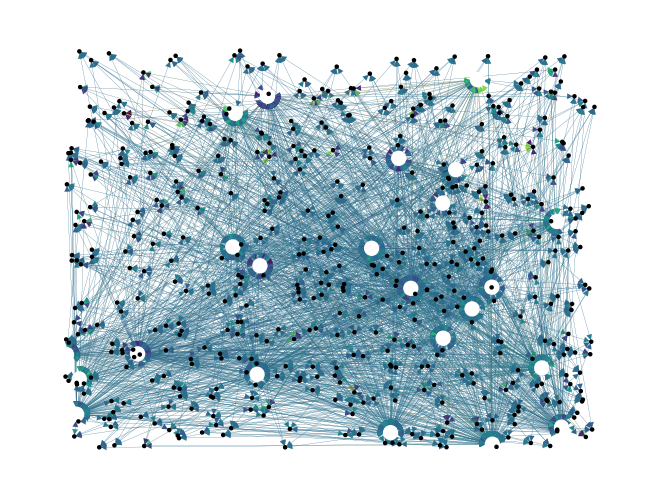

In [4]:
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np 
G = graph 

node_colours= []
node_sizes = []
for node in list(G.nodes):
    if isinstance(node,int):
        node_colours.append('black')
        node_sizes.append(5)
    else:
        node_colours.append('white')
        node_sizes.append(100)

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
vmin = np.min(weights)
vmax = np.max(weights)
cmap = plt.cm.viridis

nx.draw_random(G,node_color=node_colours,node_size=node_sizes,edgelist=edges,edge_color=weights,width=0.1,edge_cmap=cmap,vmin=vmin,vmax=vmax)

In [317]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic({'H2O':100,'H2':30,'O2':50,'H2S':1000,'NO2':200,'N2':300})
t = Traversal(graph=graph)
t.rank_small_reactions_higher = True

weighted_random_compounds = t.get_weighted_random_compounds(concentrations=gic,ceiling = 10000,max_compounds=5)
weighted_random_compounds

{'H2S': 0.625,
 'N2': 0.1875,
 'NO2': 0.12499999999999999,
 'H2O': 0.06249999999999999}

In [318]:
ranked_reactions = t.get_weighted_reaction_rankings(weighted_random_compounds = weighted_random_compounds)
ranked_reactions

{267: 13.049026972311408, 388: 3.455990865342924}

In [330]:
t.chose_reaction(ranked_reactions)

AttributeError: 'Traversal' object has no attribute 'chose_reaction'

In [328]:
eqsys = t.generate_chempy_eqsystem(index=chosen_reaction)
eqsys

In [326]:
path_available[-1]

IndexError: list index out of range